In [51]:
import math
import numpy as np
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns

from mpl_toolkits import mplot3d
from collections import defaultdict
from scipy.stats.stats import pearsonr
from scipy.stats import shapiro
from scipy.stats import normaltest
from pandas.plotting import parallel_coordinates
from kneed import KneeLocator

In [52]:
#scaling, normalization
from sklearn.preprocessing import StandardScaler, MinMaxScaler
#PCA
from sklearn.decomposition import PCA
#kmeans, dbscan, hierarchical (sklearn)
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
#evaluation
from sklearn.metrics import silhouette_score
#import dataset
from sklearn.datasets import load_iris

#distance matrix (dbscan elbow, hierarchical)
from scipy.spatial.distance import pdist, squareform
# hierarchical (scipy)
from scipy.cluster.hierarchy import linkage, dendrogram

In [149]:
df=pd.read_csv("ravdess_features.csv")

In [150]:
df["emotion"]=df["emotion"].replace(["fearful", "angry", "happy", "surprised", "neutral", "calm", "sad", "disgust"],[0,1,2,3,4,5,6,7])
df["emotional_intensity"]=df["emotional_intensity"].replace(["normal", "strong"],[0,1])
df["vocal_channel"]=df["vocal_channel"].replace(["speech", "song"],[0,1])
df["repetition"]=df["repetition"].replace(["1st", "2nd"],[0,1])
df["sex"]=df["sex"].replace(["M", "F"],[0,1])
df["statement"]=df["statement"].replace(["Dogs are sitting by the door", "Kids are talking by the door"],[0,1])

In [151]:
df["vocal_channel_fill"]=df["vocal_channel"]
df["vocal_channel_fill"]=df["vocal_channel_fill"].groupby([df["emotion"], df["emotional_intensity"]]).apply(lambda x: x.fillna(x.mode()[0]))
df["intensity_fill"]=df["intensity"]
df["intensity_fill"]=df["intensity_fill"].groupby([df["emotion"], df["emotional_intensity"]]).apply(lambda x: x.fillna(x.mean()))
df["frame_count_fill"]=df["frame_count"]
df["frame_count_fill"]=df["frame_count_fill"].groupby([df["emotion"], df["emotional_intensity"]]).apply(lambda x: x.fillna(x.mean()))

In [56]:
df.corr().loc[["length_ms", "vocal_channel_fill", "frame_count_fill", "intensity_fill", "zero_crossings_sum", "sex", "emotional_intensity", "mfcc_std", "mfcc_min", "sc_mean", "sc_std", "sc_kur", "sc_skew", "stft_mean", "stft_std", "stft_skew", "std", "min", "max"], ["length_ms", "vocal_channel_fill", "frame_count_fill", "intensity_fill", "zero_crossings_sum", "sex", "emotional_intensity", "mfcc_std", "mfcc_min", "sc_mean", "sc_std", "sc_kur", "sc_skew", "stft_mean", "stft_std", "stft_skew", "std", "min", "max"]].style.background_gradient(cmap="coolwarm", vmin=-1, vmax=1)

,length_ms,vocal_channel_fill,frame_count_fill,intensity_fill,zero_crossings_sum,sex,emotional_intensity,mfcc_std,mfcc_min,sc_mean,sc_std,sc_kur,sc_skew,stft_mean,stft_std,stft_skew,std,min,max
length_ms,1.000000,0.714061,0.762874,0.196152,0.329517,0.071584,0.114027,-0.302735,0.205996,-0.546234,-0.182306,0.292127,0.621148,-0.561395,0.409380,0.602057,0.167134,-0.070644,0.072309
vocal_channel_fill,0.714061,1.000000,0.547279,0.229994,0.145807,-0.027713,0.010405,-0.287471,0.202903,-0.493329,-0.148907,0.244722,0.541737,-0.461310,0.382703,0.489138,0.145549,-0.042430,0.046417
frame_count_fill,0.762874,0.547279,1.000000,0.140790,0.232289,0.056466,0.092486,-0.226994,0.151464,-0.421151,-0.140110,0.231393,0.483005,-0.429014,0.322356,0.458971,0.119598,-0.045295,0.044480
intensity_fill,0.196152,0.229994,0.140790,1.000000,0.446169,0.068257,0.405435,-0.903944,0.901106,-0.272522,-0.414052,0.346526,0.357941,-0.275297,0.195825,0.306799,0.806389,-0.783290,0.786313
zero_crossings_sum,0.329517,0.145807,0.232289,0.446169,1.000000,0.389077,0.254869,-0.559115,0.500559,-0.072949,-0.373711,0.186598,0.140215,-0.406511,0.115175,0.445898,0.470125,-0.420933,0.417493
sex,0.071584,-0.027713,0.056466,0.068257,0.389077,1.000000,0.000256,-0.108791,0.126288,0.042652,0.100327,-0.019193,-0.007658,-0.574827,0.578974,0.462716,0.083554,-0.052830,0.053374
emotional_intensity,0.114027,0.010405,0.092486,0.405435,0.254869,0.000256,1.000000,-0.416725,0.403562,-0.118081,-0.256610,0.233992,0.197154,-0.081052,0.031236,0.107097,0.400001,-0.416768,0.417563
mfcc_std,-0.302735,-0.287471,-0.226994,-0.903944,-0.559115,-0.108791,-0.416725,1.000000,-0.976098,0.369792,0.524719,-0.453798,-0.473588,0.365598,-0.229781,-0.411195,-0.844623,0.816134,-0.810939
mfcc_min,0.205996,0.202903,0.151464,0.901106,0.500559,0.126288,0.403562,-0.976098,1.000000,-0.285340,-0.453582,0.368018,0.360212,-0.306645,0.224710,0.330945,0.842259,-0.828536,0.822831
sc_mean,-0.546234,-0.493329,-0.421151,-0.272522,-0.072949,0.042652,-0.118081,0.369792,-0.285340,1.000000,0.529673,-0.626227,-0.823353,0.562423,-0.322951,-0.637220,-0.217910,0.174301,-0.169879


## Statistiche generali

<AxesSubplot:xlabel='stft_min', ylabel='Density'>

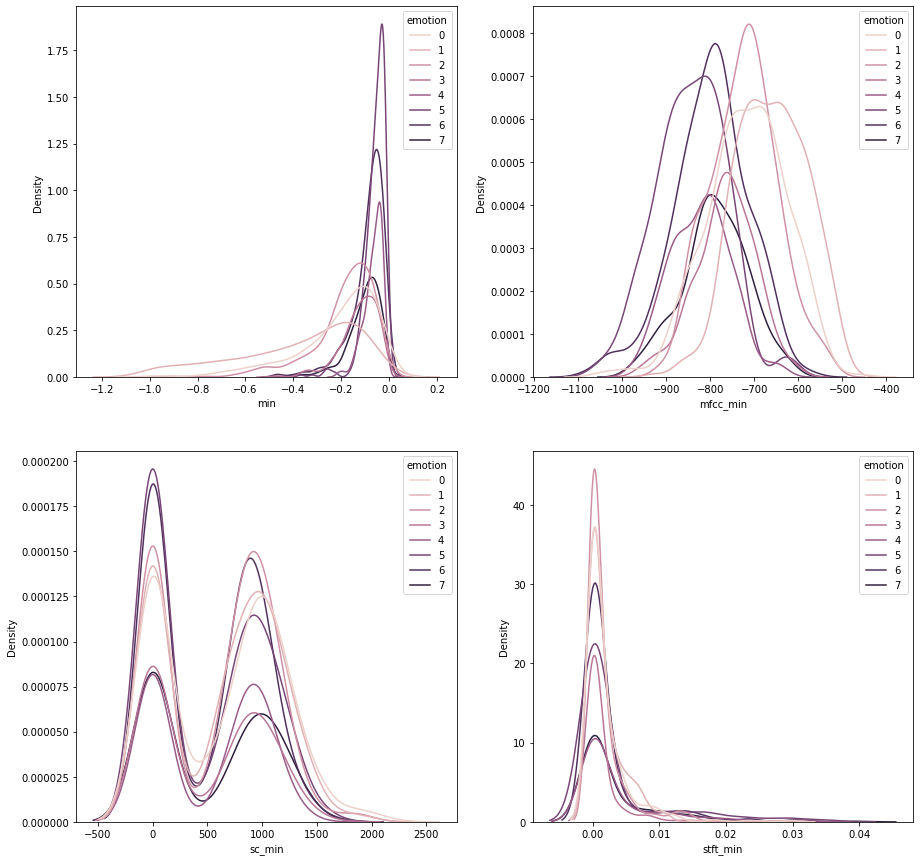

In [57]:
#min df originale
fig, axs = plt.subplots(2,2,figsize=(15,15))
sns.kdeplot(data=df, x="min", hue="emotion", ax=axs[0][0])
sns.kdeplot(data=df, x="mfcc_min", hue="emotion", ax=axs[0][1])
sns.kdeplot(data=df, x="sc_min", hue="emotion", ax=axs[1][0])
sns.kdeplot(data=df, x="stft_min", hue="emotion", ax=axs[1][1])

<AxesSubplot:xlabel='intensity_fill', ylabel='Density'>

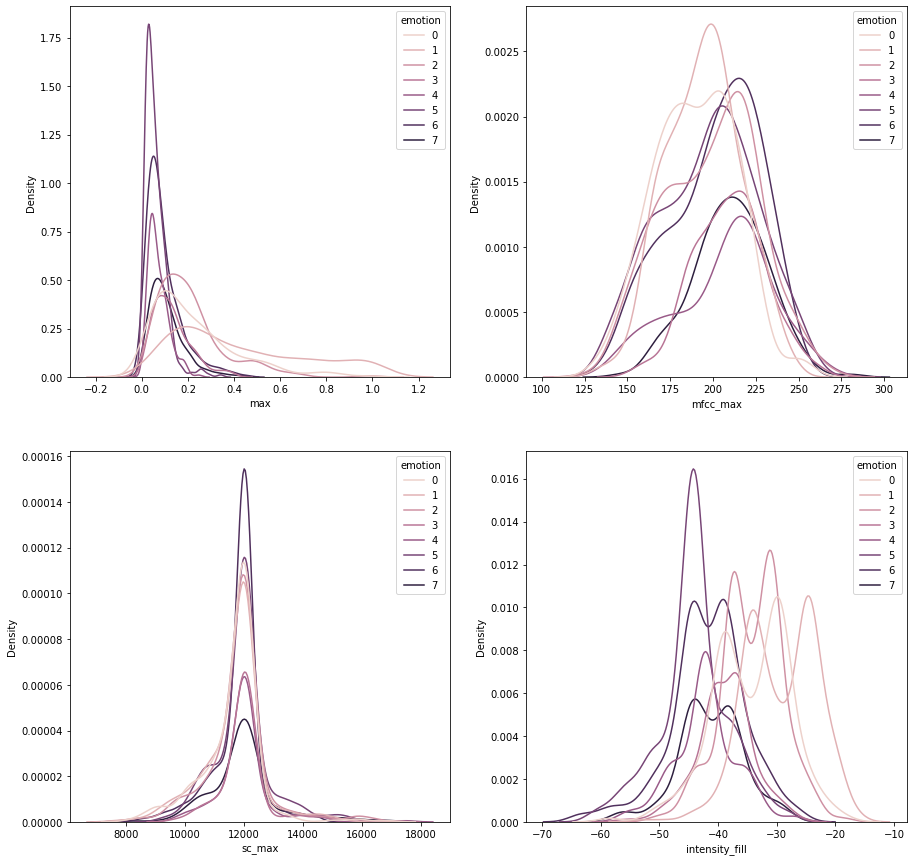

In [58]:
#max df originale
fig, axs = plt.subplots(2,2,figsize=(15,15))
sns.kdeplot(data=df, x="max", hue="emotion", ax=axs[0][0])
sns.kdeplot(data=df, x="mfcc_max", hue="emotion", ax=axs[0][1])
sns.kdeplot(data=df, x="sc_max", hue="emotion", ax=axs[1][0])
sns.kdeplot(data=df, x="intensity_fill", hue="emotion", ax=axs[1][1])

<AxesSubplot:xlabel='stft_mean', ylabel='Density'>

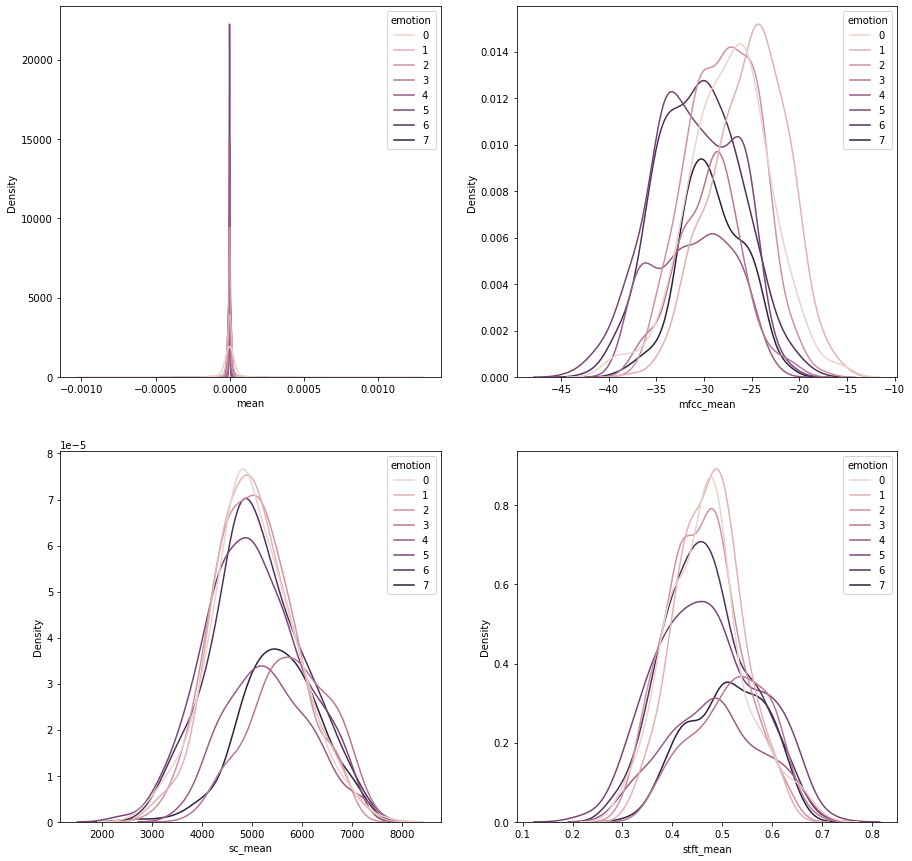

In [59]:
#mean df originale
fig, axs = plt.subplots(2,2,figsize=(15,15))
sns.kdeplot(data=df, x="mean", hue="emotion", ax=axs[0][0])
sns.kdeplot(data=df, x="mfcc_mean", hue="emotion", ax=axs[0][1])
sns.kdeplot(data=df, x="sc_mean", hue="emotion", ax=axs[1][0])
sns.kdeplot(data=df, x="stft_mean", hue="emotion", ax=axs[1][1])

<AxesSubplot:xlabel='stft_std', ylabel='Density'>

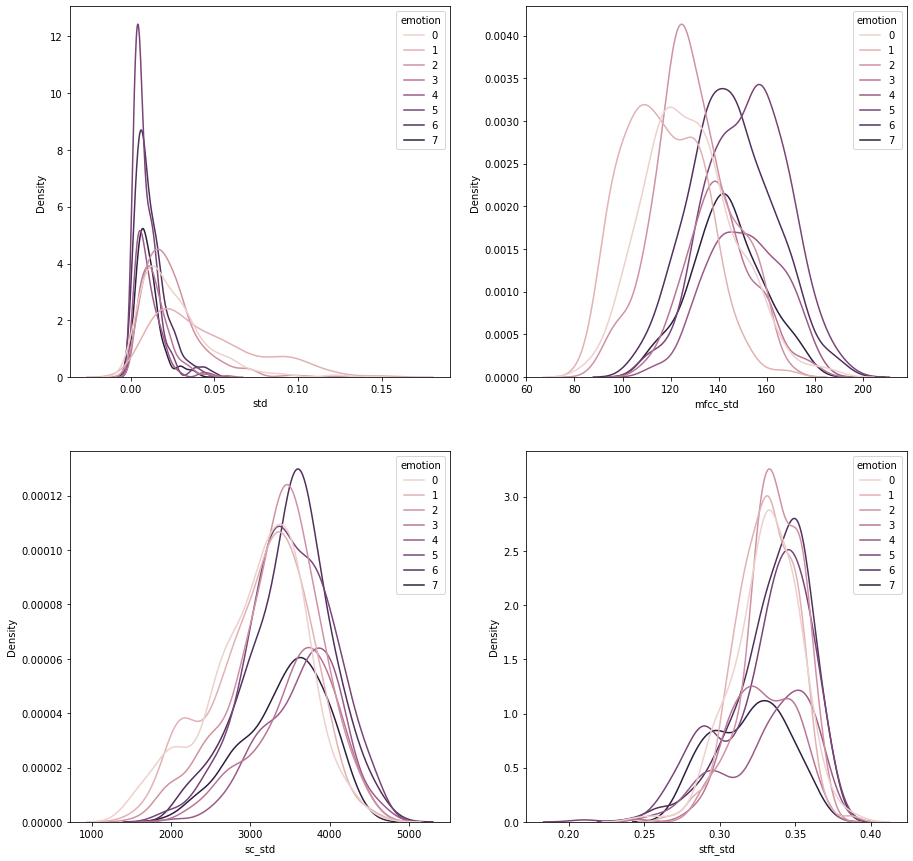

In [60]:
#std
fig, axs = plt.subplots(2,2,figsize=(15,15))
sns.kdeplot(data=df, x="std", hue="emotion", ax=axs[0][0])
sns.kdeplot(data=df, x="mfcc_std", hue="emotion", ax=axs[0][1])
sns.kdeplot(data=df, x="sc_std", hue="emotion", ax=axs[1][0])
sns.kdeplot(data=df, x="stft_std", hue="emotion", ax=axs[1][1])

<AxesSubplot:xlabel='stft_skew', ylabel='Density'>

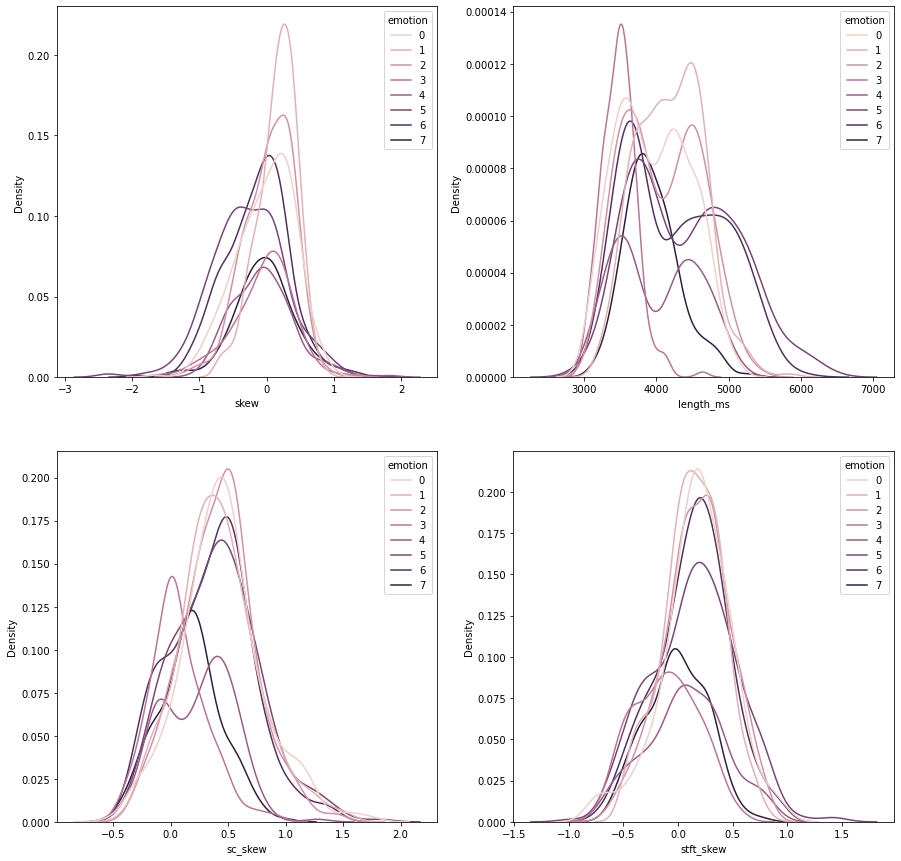

In [61]:
#skew and length
fig, axs = plt.subplots(2,2,figsize=(15,15))
sns.kdeplot(data=df, x="skew", hue="emotion", ax=axs[0][0])
sns.kdeplot(data=df, x="length_ms", hue="emotion", ax=axs[0][1])
sns.kdeplot(data=df, x="sc_skew", hue="emotion", ax=axs[1][0])
sns.kdeplot(data=df, x="stft_skew", hue="emotion", ax=axs[1][1])

<AxesSubplot:xlabel='stft_kur', ylabel='Density'>

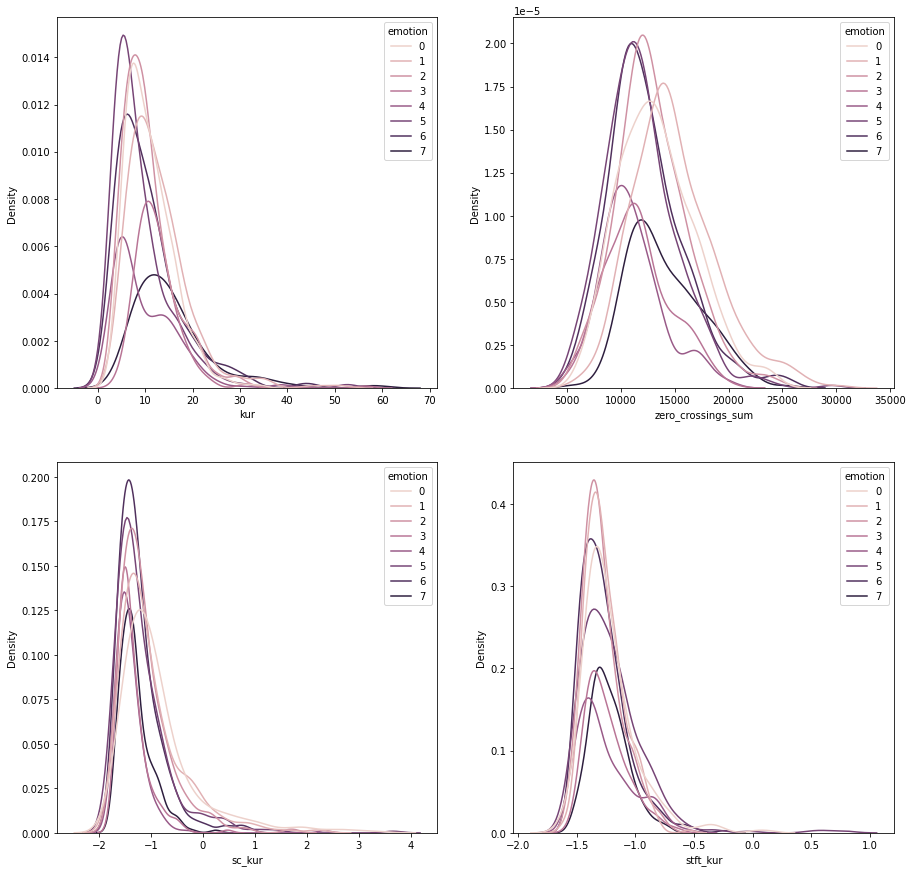

In [62]:
#zero-crossing-sum and kurtosis
fig, axs = plt.subplots(2,2,figsize=(15,15))
sns.kdeplot(data=df, x="kur", hue="emotion", ax=axs[0][0])
sns.kdeplot(data=df, x="zero_crossings_sum", hue="emotion", ax=axs[0][1])
sns.kdeplot(data=df, x="sc_kur", hue="emotion", ax=axs[1][0])
sns.kdeplot(data=df, x="stft_kur", hue="emotion", ax=axs[1][1])

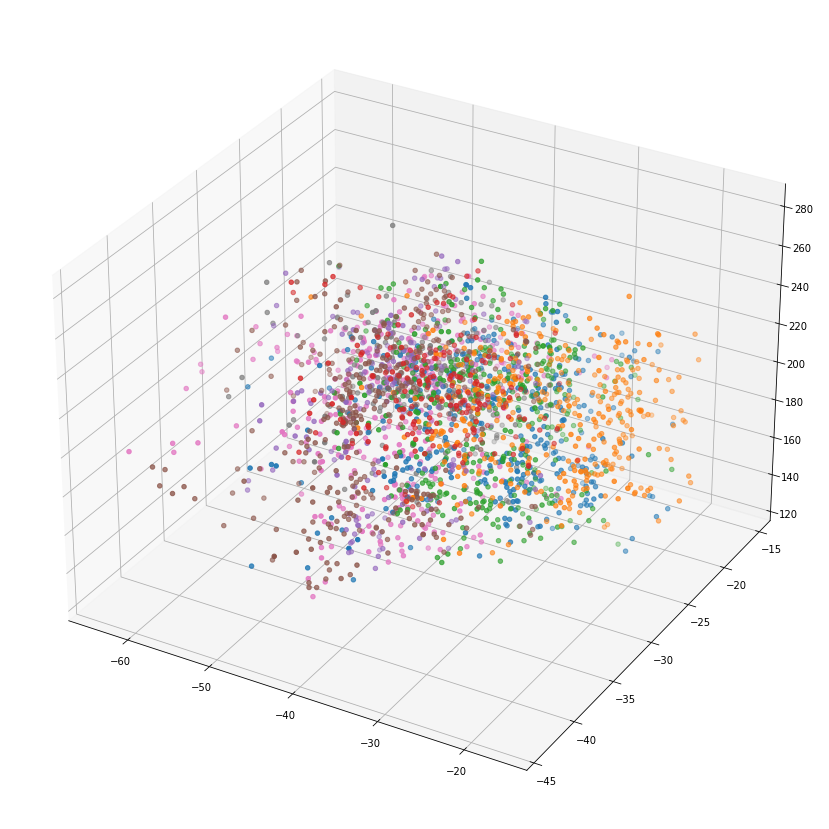

In [63]:
fig = plt.figure(figsize=(15,15))
ax = fig.add_subplot(111, projection='3d')

for s in df.emotion.unique():
    ax.scatter(df.intensity_fill[df.emotion==s],df.mfcc_mean[df.emotion==s],df.mfcc_max[df.emotion==s],label=s)

## Outliers

In [64]:
#più interessanti
"""fig, axs = plt.subplots(5,2,figsize=(15,15))
sns.boxplot(data=df, x="mfcc_mean", y="emotion", ax=axs[0][0])
sns.boxplot(data=df, x="mfcc_std", y="emotion", ax=axs[0][1])
sns.boxplot(data=df, x="mfcc_min", y="emotion", ax=axs[1][0])
sns.boxplot(data=df, x="mfcc_max", y="emotion", ax=axs[1][1])
sns.boxplot(data=df, x="std", y="emotion", ax=axs[2][0])
sns.boxplot(data=df, x="min", y="emotion", ax=axs[2][1])
sns.boxplot(data=df, x="max", y="emotion", ax=axs[3][0])
sns.boxplot(data=df, x="length_ms", y="emotion", ax=axs[3][1])
sns.boxplot(data=df, x="intensity", y="emotion", ax=axs[4][0])
sns.boxplot(data=df, x="frame_count", y="emotion", ax=axs[4][1])"""

'fig, axs = plt.subplots(5,2,figsize=(15,15))\nsns.boxplot(data=df, x="mfcc_mean", y="emotion", ax=axs[0][0])\nsns.boxplot(data=df, x="mfcc_std", y="emotion", ax=axs[0][1])\nsns.boxplot(data=df, x="mfcc_min", y="emotion", ax=axs[1][0])\nsns.boxplot(data=df, x="mfcc_max", y="emotion", ax=axs[1][1])\nsns.boxplot(data=df, x="std", y="emotion", ax=axs[2][0])\nsns.boxplot(data=df, x="min", y="emotion", ax=axs[2][1])\nsns.boxplot(data=df, x="max", y="emotion", ax=axs[3][0])\nsns.boxplot(data=df, x="length_ms", y="emotion", ax=axs[3][1])\nsns.boxplot(data=df, x="intensity", y="emotion", ax=axs[4][0])\nsns.boxplot(data=df, x="frame_count", y="emotion", ax=axs[4][1])'

# Clustering

In [152]:
#elimino le variabili non numeriche, missing values, entrate costanti, correlate più di |0.9|
df = df.drop(["emotion", "intensity_fill", "mfcc_min", "stft_mean", "min", "max", "sample_width", "frame_rate", "stft_max", "modality", "intensity", "vocal_channel", "emotional_intensity", "statement", "repetition", "actor", "sex", "channels", "sample_width", "frame_rate", "frame_width", "sc_min", "stft_min", "stft_max", "vocal_channel_fill", "frame_count"], axis=1)

In [66]:
'''dfcopy1=df.copy()
dfcopy2=df
dfcopy3=df
'''

'dfcopy1=df.copy()\ndfcopy2=df\ndfcopy3=df\n'

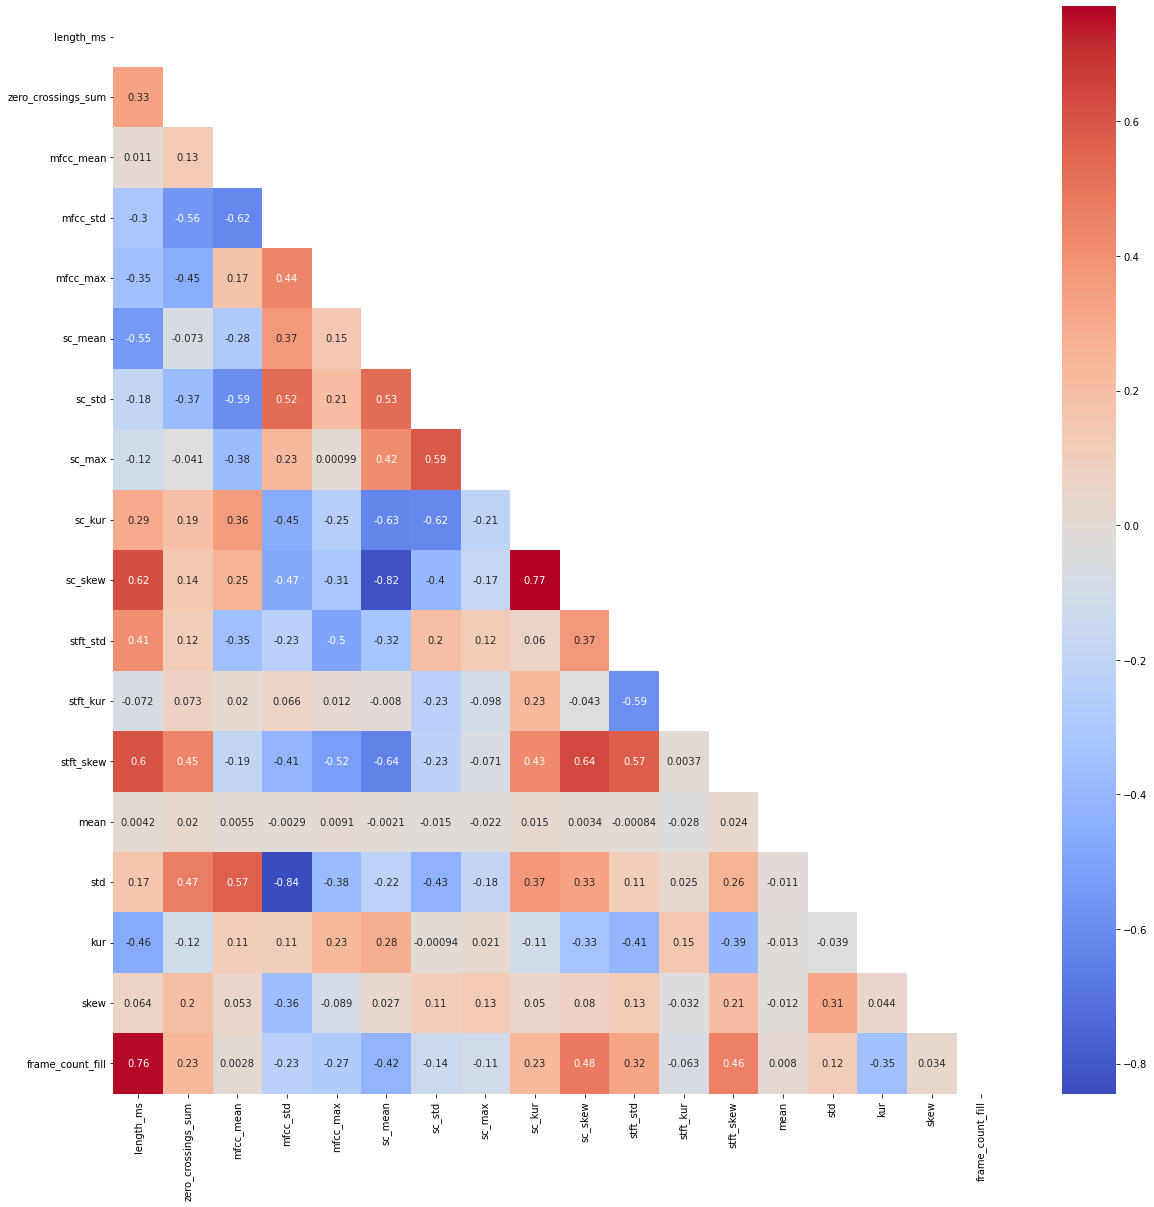

In [153]:
fig=plt.figure(figsize=(20,20))
mask = np.triu(np.ones_like(df.corr()))
dataplot = sns.heatmap(df.corr(), cmap="coolwarm", annot=True, mask=mask)
plt.show()

In [67]:
df.corr().style.background_gradient(cmap="coolwarm", vmin=-1, vmax=1)

,length_ms,zero_crossings_sum,mfcc_mean,mfcc_std,mfcc_max,sc_mean,sc_std,sc_max,sc_kur,sc_skew,stft_std,stft_kur,stft_skew,mean,std,kur,skew,frame_count_fill
length_ms,1.000000,0.329517,0.011321,-0.302735,-0.347253,-0.546234,-0.182306,-0.118781,0.292127,0.621148,0.409380,-0.072309,0.602057,0.004213,0.167134,-0.460723,0.064473,0.762874
zero_crossings_sum,0.329517,1.000000,0.130454,-0.559115,-0.448745,-0.072949,-0.373711,-0.040921,0.186598,0.140215,0.115175,0.072706,0.445898,0.020279,0.470125,-0.118101,0.201108,0.232289
mfcc_mean,0.011321,0.130454,1.000000,-0.620080,0.172355,-0.282160,-0.593395,-0.375264,0.357717,0.253241,-0.354091,0.019601,-0.185246,0.005491,0.565188,0.112305,0.053027,0.002837
mfcc_std,-0.302735,-0.559115,-0.620080,1.000000,0.438390,0.369792,0.524719,0.225939,-0.453798,-0.473588,-0.229781,0.066463,-0.411195,-0.002905,-0.844623,0.107558,-0.360223,-0.226994
mfcc_max,-0.347253,-0.448745,0.172355,0.438390,1.000000,0.151236,0.208612,0.000990,-0.248825,-0.309603,-0.497307,0.012135,-0.523619,0.009117,-0.383254,0.232757,-0.089120,-0.271507
sc_mean,-0.546234,-0.072949,-0.282160,0.369792,0.151236,1.000000,0.529673,0.415215,-0.626227,-0.823353,-0.322951,-0.007985,-0.637220,-0.002090,-0.217910,0.282102,0.026769,-0.421151
sc_std,-0.182306,-0.373711,-0.593395,0.524719,0.208612,0.529673,1.000000,0.593967,-0.619887,-0.401971,0.199808,-0.231661,-0.225841,-0.015130,-0.428090,-0.000941,0.114184,-0.140110
sc_max,-0.118781,-0.040921,-0.375264,0.225939,0.000990,0.415215,0.593967,1.000000,-0.206287,-0.169995,0.120883,-0.098248,-0.070829,-0.022471,-0.180447,0.021478,0.127236,-0.107906
sc_kur,0.292127,0.186598,0.357717,-0.453798,-0.248825,-0.626227,-0.619887,-0.206287,1.000000,0.770684,0.059976,0.230805,0.426984,0.015006,0.373452,-0.106707,0.049796,0.231393
sc_skew,0.621148,0.140215,0.253241,-0.473588,-0.309603,-0.823353,-0.401971,-0.169995,0.770684,1.000000,0.368663,-0.043084,0.635692,0.003429,0.329005,-0.332573,0.079761,0.483005


In [68]:
'''#elimino le variabili altamente correlate (>|0.8| per df, >|0.95| per dfcopy2, >|0.7| per dfcopy3)
df = df.drop(["mfcc_std", "mfcc_min", "sc_mean", "stft_skew", "std", "min"],axis=1)
dfcopy2=dfcopy2.drop(["mfcc_std", "stft_skew", "std", "min"],axis=1)
dfcopy3 = dfcopy3.drop(["length_ms", "mfcc_std", "mfcc_min", "sc_mean", "stft_skew", "std", "min", "sc_kur", "stft_std", "intensity_fill"],axis=1)'''

'#elimino le variabili altamente correlate (>|0.8| per df, >|0.95| per dfcopy2, >|0.7| per dfcopy3)\ndf = df.drop(["mfcc_std", "mfcc_min", "sc_mean", "stft_skew", "std", "min"],axis=1)\ndfcopy2=dfcopy2.drop(["mfcc_std", "stft_skew", "std", "min"],axis=1)\ndfcopy3 = dfcopy3.drop(["length_ms", "mfcc_std", "mfcc_min", "sc_mean", "stft_skew", "std", "min", "sc_kur", "stft_std", "intensity_fill"],axis=1)'

In [69]:
#dfcopy3.corr().style.background_gradient(cmap="coolwarm", vmin=-1, vmax=1)

In [70]:
#dfcopy4 = dfcopy3.drop(["mean", "max", "kur", "skew"],axis=1)

In [71]:
#dfcopy3.corr().style.background_gradient(cmap="coolwarm", vmin=-1, vmax=1)

In [72]:
#dfcopy4.corr().style.background_gradient(cmap="coolwarm", vmin=-1, vmax=1)

In [73]:
X = df.values
#X1 = dfcopy2.values
#X2 = dfcopy3.values
#X3 = dfcopy4.values
scaler = MinMaxScaler()
X_minmax = scaler.fit_transform(X)
#X_minmax1 = scaler.fit_transform(X1)
#X_minmax2 = scaler.fit_transform(X2)
#X_minmax3 = scaler.fit_transform(X3)

<AxesSubplot:ylabel='Count'>

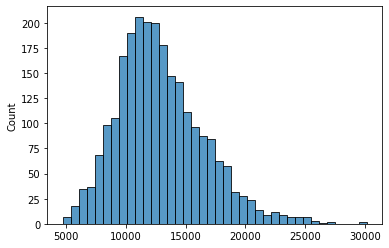

In [74]:
sns.histplot(data=X, x=X[:,1])

<AxesSubplot:ylabel='Count'>

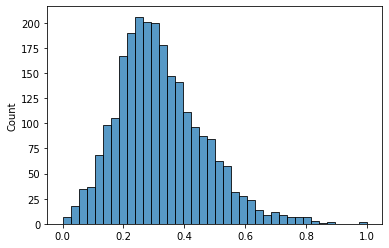

In [75]:
sns.histplot(data=X_minmax, x=X_minmax[:,1])

## Kmeans

In [76]:
kmeans = KMeans(n_clusters=4, n_init=10, max_iter=100)
kmeans.fit(X_minmax)

KMeans(max_iter=100, n_clusters=4)

<AxesSubplot:xlabel='mfcc_mean', ylabel='mfcc_max'>

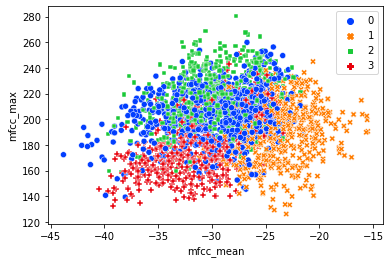

In [78]:
sns.scatterplot(data=df, x="mfcc_mean", y="mfcc_max", hue=kmeans.labels_, style=kmeans.labels_,
                palette="bright")

In [79]:
sse_list = []
for k in range(1, 50):
    kmeans = KMeans(init='k-means++', n_clusters=k, n_init=10, max_iter=100)
    kmeans.fit(X_minmax)
    sse_list.append(kmeans.inertia_)

In [80]:
'''sse_list1 = []
for k in range(1, 50):
    kmeans = KMeans(init='k-means++', n_clusters=k, n_init=10, max_iter=100)
    kmeans.fit(X_minmax1)
    sse_list1.append(kmeans.inertia_)'''

"sse_list1 = []\nfor k in range(1, 50):\n    kmeans = KMeans(init='k-means++', n_clusters=k, n_init=10, max_iter=100)\n    kmeans.fit(X_minmax1)\n    sse_list1.append(kmeans.inertia_)"

In [81]:
'''sse_list2 = []
for k in range(1, 50):
    kmeans = KMeans(init='k-means++', n_clusters=k, n_init=10, max_iter=100)
    kmeans.fit(X_minmax2)
    sse_list2.append(kmeans.inertia_)'''

"sse_list2 = []\nfor k in range(1, 50):\n    kmeans = KMeans(init='k-means++', n_clusters=k, n_init=10, max_iter=100)\n    kmeans.fit(X_minmax2)\n    sse_list2.append(kmeans.inertia_)"

In [82]:
'''sse_list3 = []
for k in range(1, 50):
    kmeans = KMeans(init='k-means++', n_clusters=k, n_init=10, max_iter=100)
    kmeans.fit(X_minmax3)
    sse_list3.append(kmeans.inertia_)'''

"sse_list3 = []\nfor k in range(1, 50):\n    kmeans = KMeans(init='k-means++', n_clusters=k, n_init=10, max_iter=100)\n    kmeans.fit(X_minmax3)\n    sse_list3.append(kmeans.inertia_)"

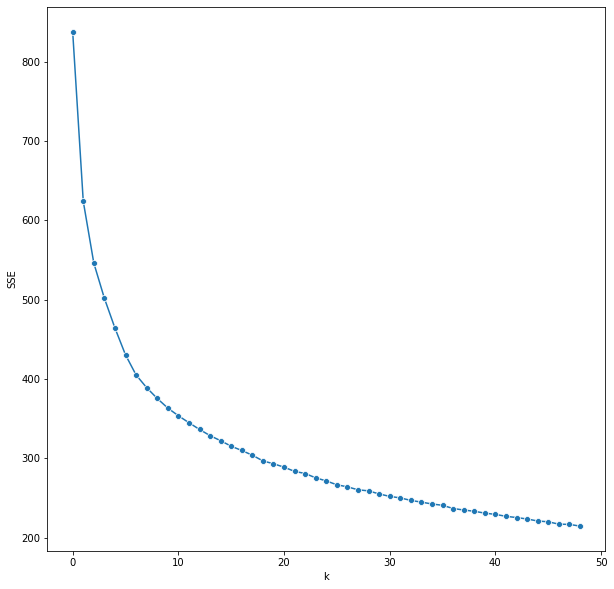

"\nplt.figure(figsize=(10,10))\nsns.lineplot(x=range(len(sse_list1)), y=sse_list1, marker='o')\nplt.ylabel('SSE')\nplt.xlabel('k')\nplt.show()\n\nplt.figure(figsize=(10,10))\nsns.lineplot(x=range(len(sse_list2)), y=sse_list2, marker='o')\nplt.ylabel('SSE')\nplt.xlabel('k')\nplt.show()\n\nplt.figure(figsize=(10,10))\nsns.lineplot(x=range(len(sse_list3)), y=sse_list3, marker='o')\nplt.ylabel('SSE')\nplt.xlabel('k')\nplt.show()"

In [83]:
plt.figure(figsize=(10,10))
sns.lineplot(x=range(len(sse_list)), y=sse_list, marker='o')
plt.ylabel('SSE')
plt.xlabel('k')
plt.show()
'''
plt.figure(figsize=(10,10))
sns.lineplot(x=range(len(sse_list1)), y=sse_list1, marker='o')
plt.ylabel('SSE')
plt.xlabel('k')
plt.show()

plt.figure(figsize=(10,10))
sns.lineplot(x=range(len(sse_list2)), y=sse_list2, marker='o')
plt.ylabel('SSE')
plt.xlabel('k')
plt.show()

plt.figure(figsize=(10,10))
sns.lineplot(x=range(len(sse_list3)), y=sse_list3, marker='o')
plt.ylabel('SSE')
plt.xlabel('k')
plt.show()'''

In [84]:
#knee locator
kn = KneeLocator(range(len(sse_list)), sse_list, curve='convex', direction='decreasing')
print(kn.knee)
'''
kn1 = KneeLocator(range(len(sse_list1)), sse_list1, curve='convex', direction='decreasing')
print(kn1.knee)

kn2 = KneeLocator(range(len(sse_list2)), sse_list2, curve='convex', direction='decreasing')
print(kn2.knee)

kn3 = KneeLocator(range(len(sse_list3)), sse_list3, curve='convex', direction='decreasing')
print(kn3.knee)'''

8


"\nkn1 = KneeLocator(range(len(sse_list1)), sse_list1, curve='convex', direction='decreasing')\nprint(kn1.knee)\n\nkn2 = KneeLocator(range(len(sse_list2)), sse_list2, curve='convex', direction='decreasing')\nprint(kn2.knee)\n\nkn3 = KneeLocator(range(len(sse_list3)), sse_list3, curve='convex', direction='decreasing')\nprint(kn3.knee)"

In [85]:
kmeans = KMeans(init='k-means++', n_clusters=kn.knee, n_init=10, max_iter=100)
kmeans.fit(X_minmax)
hist, bins = np.histogram(kmeans.labels_, bins=range(0, len(set(kmeans.labels_)) + 1))
print('labels', dict(zip(bins, hist)))
print('sse', kmeans.inertia_)
print('silhouette', silhouette_score(X_minmax, kmeans.labels_))
'''
kmeans1 = KMeans(init='k-means++', n_clusters=kn1.knee, n_init=10, max_iter=100)
kmeans1.fit(X_minmax1)
hist, bins = np.histogram(kmeans1.labels_, bins=range(0, len(set(kmeans1.labels_)) + 1))
print('labels', dict(zip(bins, hist)))
print('sse', kmeans1.inertia_)
print('silhouette', silhouette_score(X_minmax1, kmeans1.labels_))

kmeans2 = KMeans(init='k-means++', n_clusters=kn2.knee, n_init=10, max_iter=100)
kmeans2.fit(X_minmax2)
hist, bins = np.histogram(kmeans2.labels_, bins=range(0, len(set(kmeans2.labels_)) + 1))
print('labels', dict(zip(bins, hist)))
print('sse', kmeans2.inertia_)
print('silhouette', silhouette_score(X_minmax2, kmeans2.labels_))

kmeans3 = KMeans(init='k-means++', n_clusters=kn3.knee, n_init=10, max_iter=100)
kmeans3.fit(X_minmax3)
hist, bins = np.histogram(kmeans3.labels_, bins=range(0, len(set(kmeans3.labels_)) + 1))
print('labels', dict(zip(bins, hist)))
print('sse', kmeans3.inertia_)
print('silhouette', silhouette_score(X_minmax3, kmeans3.labels_))'''

labels {0: 287, 1: 368, 2: 375, 3: 317, 4: 194, 5: 344, 6: 286, 7: 281}
sse 389.13984335149314
silhouette 0.15464304330646583


"\nkmeans1 = KMeans(init='k-means++', n_clusters=kn1.knee, n_init=10, max_iter=100)\nkmeans1.fit(X_minmax1)\nhist, bins = np.histogram(kmeans1.labels_, bins=range(0, len(set(kmeans1.labels_)) + 1))\nprint('labels', dict(zip(bins, hist)))\nprint('sse', kmeans1.inertia_)\nprint('silhouette', silhouette_score(X_minmax1, kmeans1.labels_))\n\nkmeans2 = KMeans(init='k-means++', n_clusters=kn2.knee, n_init=10, max_iter=100)\nkmeans2.fit(X_minmax2)\nhist, bins = np.histogram(kmeans2.labels_, bins=range(0, len(set(kmeans2.labels_)) + 1))\nprint('labels', dict(zip(bins, hist)))\nprint('sse', kmeans2.inertia_)\nprint('silhouette', silhouette_score(X_minmax2, kmeans2.labels_))\n\nkmeans3 = KMeans(init='k-means++', n_clusters=kn3.knee, n_init=10, max_iter=100)\nkmeans3.fit(X_minmax3)\nhist, bins = np.histogram(kmeans3.labels_, bins=range(0, len(set(kmeans3.labels_)) + 1))\nprint('labels', dict(zip(bins, hist)))\nprint('sse', kmeans3.inertia_)\nprint('silhouette', silhouette_score(X_minmax3, kmeans3

In [86]:
df.head()

,length_ms,zero_crossings_sum,mfcc_mean,mfcc_std,mfcc_max,sc_mean,sc_std,sc_max,sc_kur,sc_skew,stft_std,stft_kur,stft_skew,mean,std,kur,skew,frame_count_fill
0,3737,16995,-33.485947,134.654860,171.69092,5792.550744,3328.055457,13541.959028,-1.120769,0.250940,0.335533,-1.215025,0.403514,3.844916e-07,0.014482,9.406061,0.273153,179379.0
1,3904,13906,-29.502108,130.485630,205.00770,5197.620555,4040.931570,12000.290443,-1.531204,0.219582,0.352380,-1.384174,0.290905,-7.149491e-08,0.020417,19.564187,0.292157,187387.0
2,4671,18723,-30.532463,126.577110,165.45653,4830.743037,3332.131300,12007.751173,-1.130153,0.436699,0.352270,-1.242947,0.470350,2.429985e-06,0.024317,4.881241,0.302659,224224.0
3,3637,11617,-36.059555,159.725160,190.03609,5376.446478,4053.663073,12048.223893,-1.497765,0.098802,0.360552,-1.445318,0.274756,2.373929e-07,0.003561,13.040259,-0.081014,174575.0
4,4404,15137,-31.405996,122.125824,161.13400,5146.012474,3442.724109,12025.582707,-1.167544,0.496066,0.350655,-1.366742,0.318926,8.454691e-07,0.027522,7.485109,0.414872,211411.0


In [87]:
df["klabels"]=kmeans.labels_
#dfcopy2["klabels"]=kmeans1.labels_
#dfcopy3["klabels"]=kmeans2.labels_
#dfcopy4["klabels"]=kmeans3.labels_

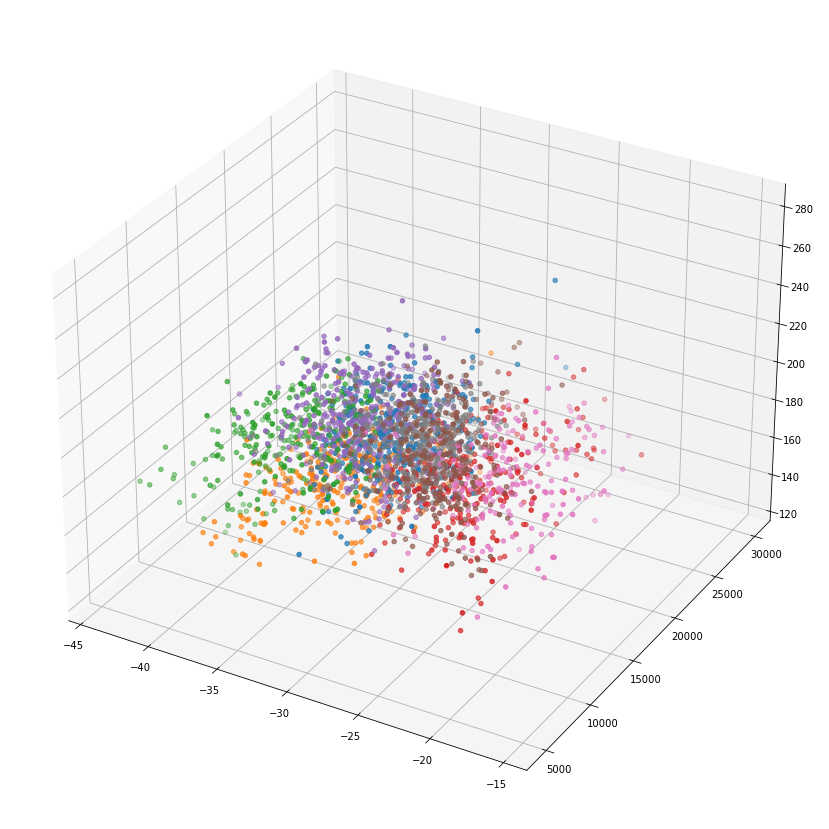

In [90]:
fig = plt.figure(figsize=(15,15))
ax = fig.add_subplot(111, projection='3d')

for s in df.klabels.unique():
    ax.scatter(df.mfcc_mean[df.klabels==s],df.zero_crossings_sum[df.klabels==s],df.mfcc_max[df.klabels==s],label=s)

<AxesSubplot:xlabel='mfcc_max', ylabel='mfcc_mean'>

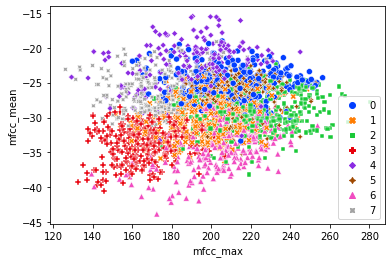

In [92]:
sns.scatterplot(data=df, x="mfcc_max", y="mfcc_mean", hue=kmeans.labels_, style=kmeans.labels_,
                palette="bright")

In [93]:
len(kmeans.cluster_centers_)

8

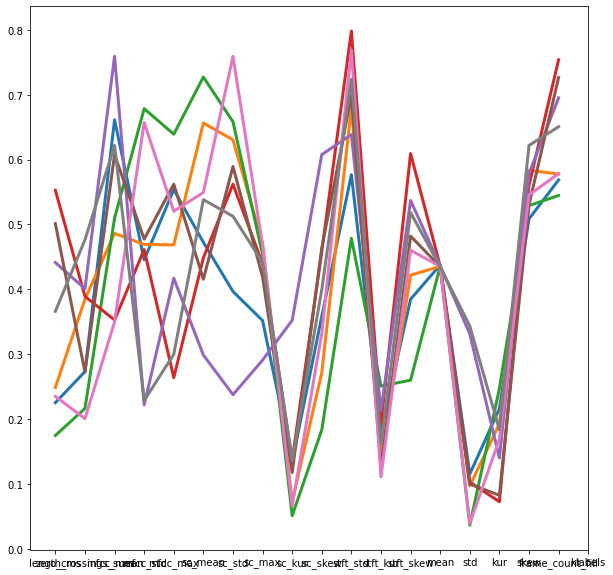

"\nplt.figure(figsize=(10,10))\nfor i in range(len(kmeans1.cluster_centers_)):\n    plt.plot(range(0, len(kmeans1.cluster_centers_[0])), kmeans1.cluster_centers_[i], label='Cluster %s' % i, linewidth=3)\nplt.xticks(range(len(dfcopy2.columns)), list(dfcopy2))\nplt.show()\n\nplt.figure(figsize=(10,10))\nfor i in range(len(kmeans2.cluster_centers_)):\n    plt.plot(range(0, len(kmeans2.cluster_centers_[0])), kmeans2.cluster_centers_[i], label='Cluster %s' % i, linewidth=3)\nplt.xticks(range(len(dfcopy3.columns)), list(dfcopy3))\nplt.show()\n\nplt.figure(figsize=(10,10))\nfor i in range(len(kmeans3.cluster_centers_)):\n    plt.plot(range(0, len(kmeans3.cluster_centers_[0])), kmeans3.cluster_centers_[i], label='Cluster %s' % i, linewidth=3)\nplt.xticks(range(len(dfcopy4.columns)), list(dfcopy4))\nplt.show()"

In [94]:
plt.figure(figsize=(10,10))
for i in range(len(kmeans.cluster_centers_)):
    plt.plot(range(0, len(kmeans.cluster_centers_[0])), kmeans.cluster_centers_[i], label='Cluster %s' % i, linewidth=3)
plt.xticks(range(len(df.columns)), list(df))
plt.show()
'''
plt.figure(figsize=(10,10))
for i in range(len(kmeans1.cluster_centers_)):
    plt.plot(range(0, len(kmeans1.cluster_centers_[0])), kmeans1.cluster_centers_[i], label='Cluster %s' % i, linewidth=3)
plt.xticks(range(len(dfcopy2.columns)), list(dfcopy2))
plt.show()

plt.figure(figsize=(10,10))
for i in range(len(kmeans2.cluster_centers_)):
    plt.plot(range(0, len(kmeans2.cluster_centers_[0])), kmeans2.cluster_centers_[i], label='Cluster %s' % i, linewidth=3)
plt.xticks(range(len(dfcopy3.columns)), list(dfcopy3))
plt.show()

plt.figure(figsize=(10,10))
for i in range(len(kmeans3.cluster_centers_)):
    plt.plot(range(0, len(kmeans3.cluster_centers_[0])), kmeans3.cluster_centers_[i], label='Cluster %s' % i, linewidth=3)
plt.xticks(range(len(dfcopy4.columns)), list(dfcopy4))
plt.show()'''

### PCA analysis

([<matplotlib.axis.XTick at 0x7fb37cad7f70>,
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

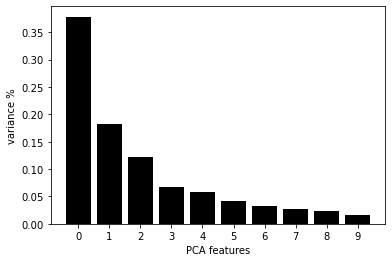

In [95]:
pca = PCA(n_components=10)
principal_components = pca.fit_transform(X_minmax)

features = range(pca.n_components_)
plt.bar(features, pca.explained_variance_ratio_, color='black')
plt.xlabel('PCA features')
plt.ylabel('variance %')
plt.xticks(features)

In [96]:
'''pca = PCA(n_components=10)
principal_components1 = pca.fit_transform(X_minmax1)

features = range(pca.n_components_)
plt.bar(features, pca.explained_variance_ratio_, color='black')
plt.xlabel('PCA features')
plt.ylabel('variance %')
plt.xticks(features)'''

"pca = PCA(n_components=10)\nprincipal_components1 = pca.fit_transform(X_minmax1)\n\nfeatures = range(pca.n_components_)\nplt.bar(features, pca.explained_variance_ratio_, color='black')\nplt.xlabel('PCA features')\nplt.ylabel('variance %')\nplt.xticks(features)"

In [97]:
'''pca = PCA(n_components=10)
principal_components2 = pca.fit_transform(X_minmax2)

features = range(pca.n_components_)
plt.bar(features, pca.explained_variance_ratio_, color='black')
plt.xlabel('PCA features')
plt.ylabel('variance %')
plt.xticks(features)'''

"pca = PCA(n_components=10)\nprincipal_components2 = pca.fit_transform(X_minmax2)\n\nfeatures = range(pca.n_components_)\nplt.bar(features, pca.explained_variance_ratio_, color='black')\nplt.xlabel('PCA features')\nplt.ylabel('variance %')\nplt.xticks(features)"

In [98]:
'''pca = PCA(n_components=9)
principal_components3 = pca.fit_transform(X_minmax3)

features = range(pca.n_components_)
plt.bar(features, pca.explained_variance_ratio_, color='black')
plt.xlabel('PCA features')
plt.ylabel('variance %')
plt.xticks(features)'''

"pca = PCA(n_components=9)\nprincipal_components3 = pca.fit_transform(X_minmax3)\n\nfeatures = range(pca.n_components_)\nplt.bar(features, pca.explained_variance_ratio_, color='black')\nplt.xlabel('PCA features')\nplt.ylabel('variance %')\nplt.xticks(features)"

2D PCA

In [101]:
pca = PCA(n_components=2)

principal_components = pca.fit_transform(X_minmax)
principal2dDf = pd.DataFrame(data = principal_components, columns = ["pc1", "pc2"])
'''
principal_components1 = pca.fit_transform(X_minmax1)
principal_components2 = pca.fit_transform(X_minmax2)
principal_components3 = pca.fit_transform(X_minmax3)

principal2dDf1 = pd.DataFrame(data = principal_components1, columns = ["pc1", "pc2"])
principal2dDf2 = pd.DataFrame(data = principal_components2, columns = ["pc1", "pc2"])
principal2dDf3 = pd.DataFrame(data = principal_components3, columns = ["pc1", "pc2"])'''

'\nprincipal_components1 = pca.fit_transform(X_minmax1)\nprincipal_components2 = pca.fit_transform(X_minmax2)\nprincipal_components3 = pca.fit_transform(X_minmax3)\n\nprincipal2dDf1 = pd.DataFrame(data = principal_components1, columns = ["pc1", "pc2"])\nprincipal2dDf2 = pd.DataFrame(data = principal_components2, columns = ["pc1", "pc2"])\nprincipal2dDf3 = pd.DataFrame(data = principal_components3, columns = ["pc1", "pc2"])'

<AxesSubplot:xlabel='pc1', ylabel='pc2'>

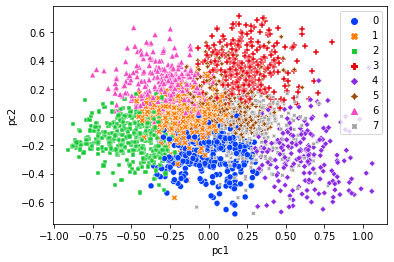

In [102]:
sns.scatterplot(data=principal2dDf, x="pc1", y="pc2", hue=kmeans.labels_, style=kmeans.labels_, palette="bright")

In [103]:
#sns.scatterplot(data=principal2dDf1, x="pc1", y="pc2", hue=kmeans1.labels_, style=kmeans1.labels_, palette="bright")

In [104]:
#sns.scatterplot(data=principal2dDf2, x="pc1", y="pc2", hue=kmeans2.labels_, style=kmeans2.labels_, palette="bright")

In [105]:
#sns.scatterplot(data=principal2dDf3, x="pc1", y="pc2", hue=kmeans3.labels_, style=kmeans3.labels_, palette="bright")

3D PCA

In [106]:
pca = PCA(n_components=3)

principal_components = pca.fit_transform(X_minmax)
principal3dDf = pd.DataFrame(data = principal_components, columns = ["pc1", "pc2", "pc3"])
'''
principal_components1 = pca.fit_transform(X_minmax1)
principal_components2 = pca.fit_transform(X_minmax2)
principal_components3 = pca.fit_transform(X_minmax3)

principal3dDf1 = pd.DataFrame(data = principal_components1, columns = ["pc1", "pc2", "pc3"])
principal3dDf2 = pd.DataFrame(data = principal_components2, columns = ["pc1", "pc2", "pc3"])
principal3dDf3 = pd.DataFrame(data = principal_components3, columns = ["pc1", "pc2", "pc3"])'''

'\nprincipal_components1 = pca.fit_transform(X_minmax1)\nprincipal_components2 = pca.fit_transform(X_minmax2)\nprincipal_components3 = pca.fit_transform(X_minmax3)\n\nprincipal3dDf1 = pd.DataFrame(data = principal_components1, columns = ["pc1", "pc2", "pc3"])\nprincipal3dDf2 = pd.DataFrame(data = principal_components2, columns = ["pc1", "pc2", "pc3"])\nprincipal3dDf3 = pd.DataFrame(data = principal_components3, columns = ["pc1", "pc2", "pc3"])'

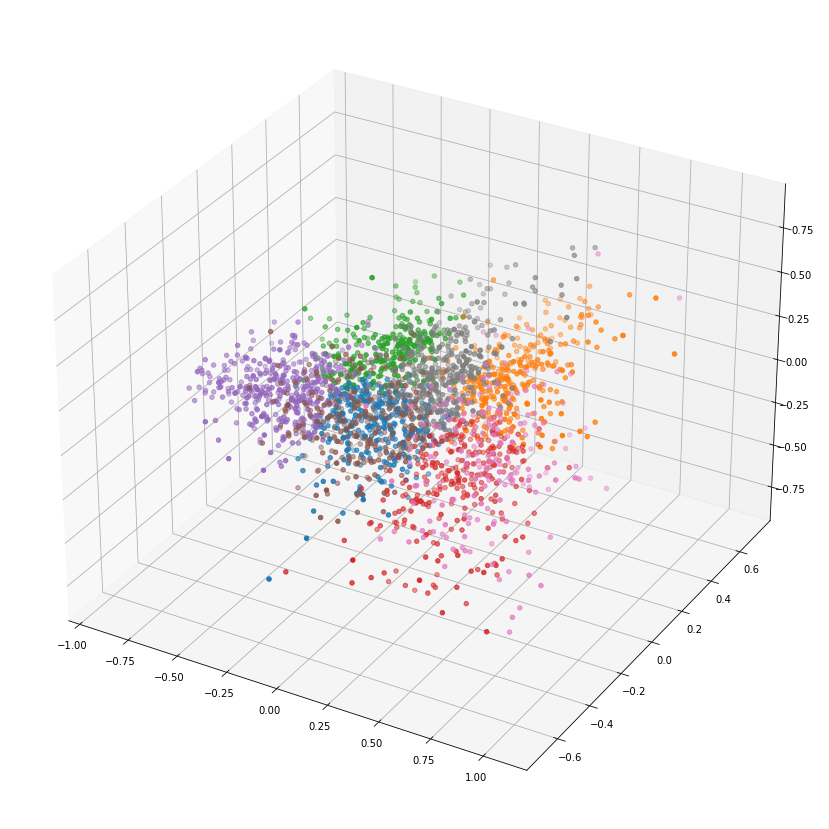

In [107]:
fig = plt.figure(figsize=(15,15))
ax = fig.add_subplot(111, projection='3d')

for s in df.klabels.unique():
    ax.scatter(principal3dDf.pc1[df.klabels==s],principal3dDf.pc2[df.klabels==s],principal3dDf.pc3[df.klabels==s],label=s)

In [108]:
'''fig = plt.figure(figsize=(15,15))
ax = fig.add_subplot(111, projection='3d')

for s in dfcopy2.klabels.unique():
    ax.scatter(principal3dDf1.pc1[dfcopy2.klabels==s],principal3dDf1.pc2[dfcopy2.klabels==s],principal3dDf1.pc3[dfcopy2.klabels==s],label=s)'''

"fig = plt.figure(figsize=(15,15))\nax = fig.add_subplot(111, projection='3d')\n\nfor s in dfcopy2.klabels.unique():\n    ax.scatter(principal3dDf1.pc1[dfcopy2.klabels==s],principal3dDf1.pc2[dfcopy2.klabels==s],principal3dDf1.pc3[dfcopy2.klabels==s],label=s)"

In [109]:
'''fig = plt.figure(figsize=(15,15))
ax = fig.add_subplot(111, projection='3d')

for s in dfcopy3.klabels.unique():
    ax.scatter(principal3dDf2.pc1[df.klabels==s],principal3dDf2.pc2[df.klabels==s],principal3dDf2.pc3[df.klabels==s],label=s)'''

"fig = plt.figure(figsize=(15,15))\nax = fig.add_subplot(111, projection='3d')\n\nfor s in dfcopy3.klabels.unique():\n    ax.scatter(principal3dDf2.pc1[df.klabels==s],principal3dDf2.pc2[df.klabels==s],principal3dDf2.pc3[df.klabels==s],label=s)"

In [110]:
'''fig = plt.figure(figsize=(15,15))
ax = fig.add_subplot(111, projection='3d')

for s in dfcopy4.klabels.unique():
    ax.scatter(principal3dDf3.pc1[df.klabels==s],principal3dDf3.pc2[df.klabels==s],principal3dDf3.pc3[df.klabels==s],label=s)'''

"fig = plt.figure(figsize=(15,15))\nax = fig.add_subplot(111, projection='3d')\n\nfor s in dfcopy4.klabels.unique():\n    ax.scatter(principal3dDf3.pc1[df.klabels==s],principal3dDf3.pc2[df.klabels==s],principal3dDf3.pc3[df.klabels==s],label=s)"

In [111]:
principal3dDf["klabels"]=kmeans.labels_
#principal3dDf1["klabels"]=kmeans1.labels_
#principal3dDf2["klabels"]=kmeans2.labels_
#principal3dDf3["klabels"]=kmeans3.labels_

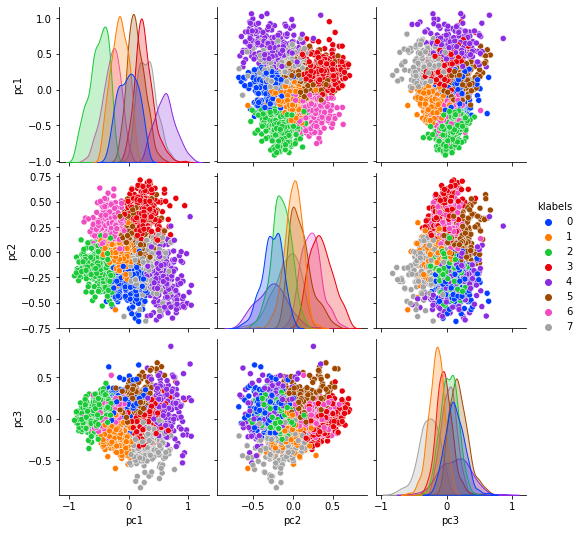

In [112]:
sns.pairplot(data=principal3dDf, hue="klabels", palette="bright")
plt.show()

In [113]:
#sns.pairplot(data=principal3dDf1, hue="klabels", palette="bright")
#plt.show()

In [114]:
#sns.pairplot(data=principal3dDf2, hue="klabels", palette="bright")
#plt.show()

In [115]:
#sns.pairplot(data=principal3dDf3, hue="klabels", palette="bright")
#plt.show()

## DBScan

In [116]:
df.head()

,length_ms,zero_crossings_sum,mfcc_mean,mfcc_std,mfcc_max,sc_mean,sc_std,sc_max,sc_kur,sc_skew,stft_std,stft_kur,stft_skew,mean,std,kur,skew,frame_count_fill,klabels
0,3737,16995,-33.485947,134.654860,171.69092,5792.550744,3328.055457,13541.959028,-1.120769,0.250940,0.335533,-1.215025,0.403514,3.844916e-07,0.014482,9.406061,0.273153,179379.0,1
1,3904,13906,-29.502108,130.485630,205.00770,5197.620555,4040.931570,12000.290443,-1.531204,0.219582,0.352380,-1.384174,0.290905,-7.149491e-08,0.020417,19.564187,0.292157,187387.0,1
2,4671,18723,-30.532463,126.577110,165.45653,4830.743037,3332.131300,12007.751173,-1.130153,0.436699,0.352270,-1.242947,0.470350,2.429985e-06,0.024317,4.881241,0.302659,224224.0,3
3,3637,11617,-36.059555,159.725160,190.03609,5376.446478,4053.663073,12048.223893,-1.497765,0.098802,0.360552,-1.445318,0.274756,2.373929e-07,0.003561,13.040259,-0.081014,174575.0,6
4,4404,15137,-31.405996,122.125824,161.13400,5146.012474,3442.724109,12025.582707,-1.167544,0.496066,0.350655,-1.366742,0.318926,8.454691e-07,0.027522,7.485109,0.414872,211411.0,3


In [117]:
dist = pdist(X_minmax, 'euclidean')
dist = squareform(dist)
'''
dist1 = pdist(X_minmax1, 'euclidean')
dist1 = squareform(dist1)

dist2 = pdist(X_minmax2, 'euclidean')
dist2 = squareform(dist2)

dist3 = pdist(X_minmax3, 'euclidean')
dist3 = squareform(dist3)'''

"\ndist1 = pdist(X_minmax1, 'euclidean')\ndist1 = squareform(dist1)\n\ndist2 = pdist(X_minmax2, 'euclidean')\ndist2 = squareform(dist2)\n\ndist3 = pdist(X_minmax3, 'euclidean')\ndist3 = squareform(dist3)"

In [118]:
k=5
kth_distances = []
for d in dist:  # d is a vector containing distances between the ith record and all the others
    index_kth_distance = np.argsort(d)[k]  # take the index of the kth nearest neighbor
    kth_distances.append(d[index_kth_distance])  # store the distance in a list
'''
kth_distances1 = []
for d in dist1:
    index_kth_distance = np.argsort(d)[k] 
    kth_distances1.append(d[index_kth_distance])  

kth_distances2 = []
for d in dist2: 
    index_kth_distance = np.argsort(d)[k]  
    kth_distances2.append(d[index_kth_distance]) 
    
kth_distances3 = []
for d in dist3: 
    index_kth_distance = np.argsort(d)[k]  
    kth_distances3.append(d[index_kth_distance])'''

'\nkth_distances1 = []\nfor d in dist1:\n    index_kth_distance = np.argsort(d)[k] \n    kth_distances1.append(d[index_kth_distance])  \n\nkth_distances2 = []\nfor d in dist2: \n    index_kth_distance = np.argsort(d)[k]  \n    kth_distances2.append(d[index_kth_distance]) \n    \nkth_distances3 = []\nfor d in dist3: \n    index_kth_distance = np.argsort(d)[k]  \n    kth_distances3.append(d[index_kth_distance])'

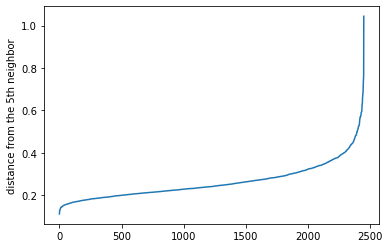

"\nplt.plot(range(0, len(kth_distances1)), sorted(kth_distances1))\nplt.ylabel('distance from the {}th neighbor'.format(k))\nplt.show()\n\nplt.plot(range(0, len(kth_distances2)), sorted(kth_distances2))\nplt.ylabel('distance from the {}th neighbor'.format(k))\nplt.show()\n\nplt.plot(range(0, len(kth_distances3)), sorted(kth_distances3))\nplt.ylabel('distance from the {}th neighbor'.format(k))\nplt.show()"

In [119]:
plt.plot(range(0, len(kth_distances)), sorted(kth_distances))
plt.ylabel('distance from the {}th neighbor'.format(k))
plt.show()
'''
plt.plot(range(0, len(kth_distances1)), sorted(kth_distances1))
plt.ylabel('distance from the {}th neighbor'.format(k))
plt.show()

plt.plot(range(0, len(kth_distances2)), sorted(kth_distances2))
plt.ylabel('distance from the {}th neighbor'.format(k))
plt.show()

plt.plot(range(0, len(kth_distances3)), sorted(kth_distances3))
plt.ylabel('distance from the {}th neighbor'.format(k))
plt.show()'''

In [120]:
#knee locator
kn = KneeLocator(range(len(kth_distances)), sorted(kth_distances), curve='convex', direction='increasing')
optimal_eps=np.interp(kn.knee, range(len(kth_distances)), sorted(kth_distances))
optimal_eps

0.4984226280905469

In [121]:
'''kn = KneeLocator(range(len(kth_distances1)), sorted(kth_distances1), curve='convex', direction='increasing')
optimal_eps1=np.interp(kn.knee, range(len(kth_distances1)), sorted(kth_distances1))
optimal_eps1'''

"kn = KneeLocator(range(len(kth_distances1)), sorted(kth_distances1), curve='convex', direction='increasing')\noptimal_eps1=np.interp(kn.knee, range(len(kth_distances1)), sorted(kth_distances1))\noptimal_eps1"

In [122]:
'''kn = KneeLocator(range(len(kth_distances2)), sorted(kth_distances2), curve='convex', direction='increasing')
optimal_eps2=np.interp(kn.knee, range(len(kth_distances2)), sorted(kth_distances2))
optimal_eps2'''

"kn = KneeLocator(range(len(kth_distances2)), sorted(kth_distances2), curve='convex', direction='increasing')\noptimal_eps2=np.interp(kn.knee, range(len(kth_distances2)), sorted(kth_distances2))\noptimal_eps2"

In [123]:
'''kn = KneeLocator(range(len(kth_distances3)), sorted(kth_distances3), curve='convex', direction='increasing')
optimal_eps3=np.interp(kn.knee, range(len(kth_distances3)), sorted(kth_distances3))
optimal_eps3'''

"kn = KneeLocator(range(len(kth_distances3)), sorted(kth_distances3), curve='convex', direction='increasing')\noptimal_eps3=np.interp(kn.knee, range(len(kth_distances3)), sorted(kth_distances3))\noptimal_eps3"

In [124]:
dbscan = DBSCAN(eps=optimal_eps, min_samples=5)
dbscan.fit(X_minmax)
hist, bins = np.histogram(dbscan.labels_, bins=range(0, len(set(dbscan.labels_)) + 1))
print('labels', dict(zip(bins, hist)))
print('silhouette', silhouette_score(X_minmax, dbscan.labels_))
'''
dbscan1 = DBSCAN(eps=optimal_eps1, min_samples=5)
dbscan1.fit(X_minmax1)
hist, bins = np.histogram(dbscan1.labels_, bins=range(0, len(set(dbscan1.labels_)) + 1))
print('labels', dict(zip(bins, hist)))
print('silhouette', silhouette_score(X_minmax1, dbscan1.labels_))

dbscan2 = DBSCAN(eps=optimal_eps2, min_samples=5)
dbscan2.fit(X_minmax2)
hist, bins = np.histogram(dbscan2.labels_, bins=range(0, len(set(dbscan2.labels_)) + 1))
print('labels', dict(zip(bins, hist)))
print('silhouette', silhouette_score(X_minmax2, dbscan2.labels_))

dbscan3 = DBSCAN(eps=optimal_eps3, min_samples=5)
dbscan3.fit(X_minmax3)
hist, bins = np.histogram(dbscan3.labels_, bins=range(0, len(set(dbscan3.labels_)) + 1))
print('labels', dict(zip(bins, hist)))
print('silhouette', silhouette_score(X_minmax3, dbscan3.labels_))'''

labels {0: 2408, 1: 22, 2: 0}
silhouette 0.1998691726847618


"\ndbscan1 = DBSCAN(eps=optimal_eps1, min_samples=5)\ndbscan1.fit(X_minmax1)\nhist, bins = np.histogram(dbscan1.labels_, bins=range(0, len(set(dbscan1.labels_)) + 1))\nprint('labels', dict(zip(bins, hist)))\nprint('silhouette', silhouette_score(X_minmax1, dbscan1.labels_))\n\ndbscan2 = DBSCAN(eps=optimal_eps2, min_samples=5)\ndbscan2.fit(X_minmax2)\nhist, bins = np.histogram(dbscan2.labels_, bins=range(0, len(set(dbscan2.labels_)) + 1))\nprint('labels', dict(zip(bins, hist)))\nprint('silhouette', silhouette_score(X_minmax2, dbscan2.labels_))\n\ndbscan3 = DBSCAN(eps=optimal_eps3, min_samples=5)\ndbscan3.fit(X_minmax3)\nhist, bins = np.histogram(dbscan3.labels_, bins=range(0, len(set(dbscan3.labels_)) + 1))\nprint('labels', dict(zip(bins, hist)))\nprint('silhouette', silhouette_score(X_minmax3, dbscan3.labels_))"

In [125]:
df["dbscan_labels"]=dbscan.labels_
#dfcopy2["dbscan_labels"]=dbscan1.labels_
#dfcopy3["dbscan_labels"]=dbscan2.labels_
#dfcopy4["dbscan_labels"]=dbscan3.labels_

In [126]:
sorted_df = df.sort_values(by="dbscan_labels")
#sorted_df1 = dfcopy2.sort_values(by="dbscan_labels")
#sorted_df2 = dfcopy3.sort_values(by="dbscan_labels")
#sorted_df3 = dfcopy4.sort_values(by="dbscan_labels")
sorted_df

,length_ms,zero_crossings_sum,mfcc_mean,mfcc_std,mfcc_max,sc_mean,sc_std,sc_max,sc_kur,sc_skew,stft_std,stft_kur,stft_skew,mean,std,kur,skew,frame_count_fill,klabels,dbscan_labels
1992,4171,24320,-20.780096,84.42982,145.47644,4410.232172,1587.001979,11985.300650,3.362251,1.062382,0.311406,-0.831323,0.518380,5.868765e-08,0.089374,14.092951,0.035143,200200.0,4,-1
2253,5906,13307,-33.255653,134.62112,173.96362,2454.041294,2404.771368,12040.844754,3.657953,1.825436,0.316572,0.794669,1.465815,-2.465882e-06,0.015186,4.549264,-0.325173,283483.0,4,-1
2102,3437,8605,-36.383682,189.12674,207.41885,7388.504600,3696.121989,12079.288790,-1.207742,-0.365248,0.266053,-0.246777,-0.686840,1.343066e-07,0.000787,55.833812,-0.455829,164964.0,2,-1
1797,3337,6427,-20.810501,125.79651,201.45715,4256.055403,2354.869904,10808.879804,-0.853370,0.451838,0.298777,-0.826186,-0.644269,-9.435575e-04,0.026629,15.353364,-0.710158,160160.0,0,-1
676,3504,10667,-28.884802,156.27405,239.61609,5651.952475,3039.794240,11151.593406,-1.498082,-0.205387,0.315858,-1.226809,-0.220761,7.220722e-06,0.006063,12.625639,0.006728,-1.0,2,-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1427,3537,13077,-29.124308,120.28164,183.37820,4597.655209,3624.155925,11925.628718,-1.245150,0.334428,0.348048,-1.172609,0.518727,1.517170e-07,0.038057,11.052940,0.380899,-1.0,1,1
869,3770,12087,-32.684746,142.48247,219.09021,4973.468158,3995.252011,14129.867514,-1.484232,0.271769,0.349477,-1.342223,0.331307,2.369155e-07,0.012115,21.449223,0.607727,-1.0,6,1
2245,4338,13251,-31.049019,130.22443,191.87555,4433.526532,3491.013361,12000.000156,-1.084673,0.488453,0.359981,-1.377848,0.392818,-2.865493e-06,0.015444,8.344269,0.189613,-1.0,1,1
1238,4471,12683,-26.245222,125.15322,194.41292,5471.287233,3883.486083,12094.995554,-1.458286,0.466744,0.338388,-1.448095,0.093049,2.539209e-06,0.017703,8.091365,-0.415216,-1.0,1,1


In [127]:
X_val=sorted_df.values
#X_val1=sorted_df1.values
#X_val2=sorted_df2.values
#X_val3=sorted_df3.values

In [128]:
dist = pdist(X_val, 'euclidean')
dist = squareform(dist)
'''
dist1 = pdist(X_val1, 'euclidean')
dist1 = squareform(dist1)

dist2 = pdist(X_val2, 'euclidean')
dist2 = squareform(dist2)

dist3 = pdist(X_val3, 'euclidean')
dist3 = squareform(dist3)'''

"\ndist1 = pdist(X_val1, 'euclidean')\ndist1 = squareform(dist1)\n\ndist2 = pdist(X_val2, 'euclidean')\ndist2 = squareform(dist2)\n\ndist3 = pdist(X_val3, 'euclidean')\ndist3 = squareform(dist3)"

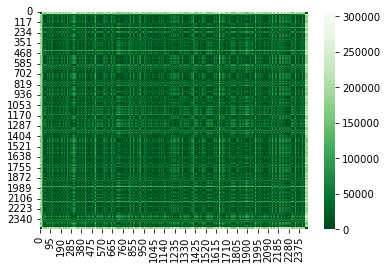

'\nsns.heatmap(dist1, cmap="Greens_r", annot=False)\nplt.show()\n\nsns.heatmap(dist2, cmap="Greens_r", annot=False)\nplt.show()\n\nsns.heatmap(dist3, cmap="Greens_r", annot=False)\nplt.show()'

In [129]:
sns.heatmap(dist, cmap="Greens_r", annot=False)
plt.show()
'''
sns.heatmap(dist1, cmap="Greens_r", annot=False)
plt.show()

sns.heatmap(dist2, cmap="Greens_r", annot=False)
plt.show()

sns.heatmap(dist3, cmap="Greens_r", annot=False)
plt.show()'''

## Hierarchical clustering

In [130]:
def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack(
        [model.children_, model.distances_, counts]
    ).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)

### Ward linkage

In [131]:
model_ward = AgglomerativeClustering(distance_threshold=0, n_clusters=None, affinity='euclidean', linkage='ward')
model_ward = model_ward.fit(X_minmax)
'''
model1_ward = AgglomerativeClustering(distance_threshold=0, n_clusters=None, affinity='euclidean', linkage='ward')
model1_ward = model1_ward.fit(X_minmax1)

model2_ward = AgglomerativeClustering(distance_threshold=0, n_clusters=None, affinity='euclidean', linkage='ward')
model2_ward = model2_ward.fit(X_minmax2)

model3_ward = AgglomerativeClustering(distance_threshold=0, n_clusters=None, affinity='euclidean', linkage='ward')
model3_ward = model3_ward.fit(X_minmax3)'''

"\nmodel1_ward = AgglomerativeClustering(distance_threshold=0, n_clusters=None, affinity='euclidean', linkage='ward')\nmodel1_ward = model1_ward.fit(X_minmax1)\n\nmodel2_ward = AgglomerativeClustering(distance_threshold=0, n_clusters=None, affinity='euclidean', linkage='ward')\nmodel2_ward = model2_ward.fit(X_minmax2)\n\nmodel3_ward = AgglomerativeClustering(distance_threshold=0, n_clusters=None, affinity='euclidean', linkage='ward')\nmodel3_ward = model3_ward.fit(X_minmax3)"

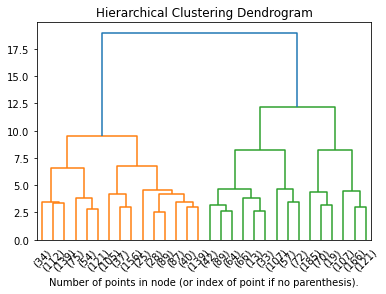

'\nplt.title("Hierarchical Clustering Dendrogram")\nplot_dendrogram(model1_ward, truncate_mode="lastp")\nplt.xlabel("Number of points in node (or index of point if no parenthesis).")\nplt.show()\n\nplt.title("Hierarchical Clustering Dendrogram")\nplot_dendrogram(model2_ward, truncate_mode="lastp")\nplt.xlabel("Number of points in node (or index of point if no parenthesis).")\nplt.show()\n\n\nplt.title("Hierarchical Clustering Dendrogram")\nplot_dendrogram(model3_ward, truncate_mode="lastp")\nplt.xlabel("Number of points in node (or index of point if no parenthesis).")\nplt.show()'

In [132]:
plt.title("Hierarchical Clustering Dendrogram")
plot_dendrogram(model_ward, truncate_mode="lastp")
plt.xlabel("Number of points in node (or index of point if no parenthesis).")
plt.show()
'''
plt.title("Hierarchical Clustering Dendrogram")
plot_dendrogram(model1_ward, truncate_mode="lastp")
plt.xlabel("Number of points in node (or index of point if no parenthesis).")
plt.show()

plt.title("Hierarchical Clustering Dendrogram")
plot_dendrogram(model2_ward, truncate_mode="lastp")
plt.xlabel("Number of points in node (or index of point if no parenthesis).")
plt.show()


plt.title("Hierarchical Clustering Dendrogram")
plot_dendrogram(model3_ward, truncate_mode="lastp")
plt.xlabel("Number of points in node (or index of point if no parenthesis).")
plt.show()'''

In [143]:
model3_ward = AgglomerativeClustering(distance_threshold=None, n_clusters=2, affinity='euclidean', linkage='ward')
model3_ward = model3_ward.fit(X_minmax)
count0 = 0
count1 = 0
count2 = 0
for i in range(len(model3_ward.labels_)):
    if (model3_ward.labels_[i] == 0):
        count0 = count0 + 1
    elif (model3_ward.labels_[i] == 1):
        count1 = count1 + 1
    else:
        count2 = count2 + 1
print(count0, count1, count2)

1211 1241 0


<AxesSubplot:xlabel='mfcc_max', ylabel='mfcc_mean'>

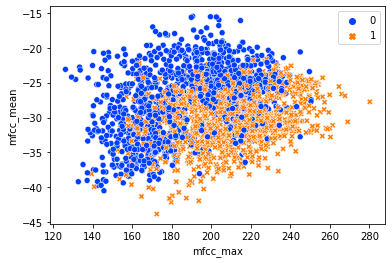

In [144]:
model3_ward = AgglomerativeClustering(distance_threshold=None, n_clusters=2, affinity='euclidean', linkage='ward')
model3_ward = model3_ward.fit(X_minmax)

sns.scatterplot(data=df, x="mfcc_max", y="mfcc_mean", hue=model3_ward.labels_, style=model3_ward.labels_,
                palette="bright")

### Average linkage

In [136]:
model_avg = AgglomerativeClustering(distance_threshold=0, n_clusters=None, affinity='euclidean', linkage='average')
model_avg = model_avg.fit(X_minmax)
'''
model1_avg = AgglomerativeClustering(distance_threshold=0, n_clusters=None, affinity='euclidean', linkage='average')
model1_avg = model1_avg.fit(X_minmax1)

model2_avg = AgglomerativeClustering(distance_threshold=0, n_clusters=None, affinity='euclidean', linkage='average')
model2_avg = model2_avg.fit(X_minmax2)

model3_avg = AgglomerativeClustering(distance_threshold=0, n_clusters=None, affinity='euclidean', linkage='average')
model3_avg = model3_avg.fit(X_minmax3)'''

"\nmodel1_avg = AgglomerativeClustering(distance_threshold=0, n_clusters=None, affinity='euclidean', linkage='average')\nmodel1_avg = model1_avg.fit(X_minmax1)\n\nmodel2_avg = AgglomerativeClustering(distance_threshold=0, n_clusters=None, affinity='euclidean', linkage='average')\nmodel2_avg = model2_avg.fit(X_minmax2)\n\nmodel3_avg = AgglomerativeClustering(distance_threshold=0, n_clusters=None, affinity='euclidean', linkage='average')\nmodel3_avg = model3_avg.fit(X_minmax3)"

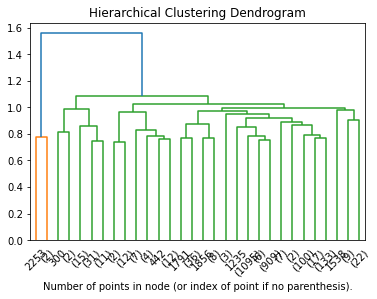

'\nplt.title("Hierarchical Clustering Dendrogram")\nplot_dendrogram(model1_avg, truncate_mode="lastp")\nplt.xlabel("Number of points in node (or index of point if no parenthesis).")\nplt.show()\n\nplt.title("Hierarchical Clustering Dendrogram")\nplot_dendrogram(model2_avg, truncate_mode="lastp")\nplt.xlabel("Number of points in node (or index of point if no parenthesis).")\nplt.show()\n\nplt.title("Hierarchical Clustering Dendrogram")\nplot_dendrogram(model3_avg, truncate_mode="lastp")\nplt.xlabel("Number of points in node (or index of point if no parenthesis).")\nplt.show()'

In [138]:
plt.title("Hierarchical Clustering Dendrogram")
plot_dendrogram(model_avg, truncate_mode="lastp")
plt.xlabel("Number of points in node (or index of point if no parenthesis).")
plt.show()
'''
plt.title("Hierarchical Clustering Dendrogram")
plot_dendrogram(model1_avg, truncate_mode="lastp")
plt.xlabel("Number of points in node (or index of point if no parenthesis).")
plt.show()

plt.title("Hierarchical Clustering Dendrogram")
plot_dendrogram(model2_avg, truncate_mode="lastp")
plt.xlabel("Number of points in node (or index of point if no parenthesis).")
plt.show()

plt.title("Hierarchical Clustering Dendrogram")
plot_dendrogram(model3_avg, truncate_mode="lastp")
plt.xlabel("Number of points in node (or index of point if no parenthesis).")
plt.show()'''

### Maximum linkage

In [139]:
model_complete = AgglomerativeClustering(distance_threshold=0, n_clusters=None, affinity='euclidean', linkage='complete')
model_complete = model_complete.fit(X_minmax)
'''
model1_complete = AgglomerativeClustering(distance_threshold=0, n_clusters=None, affinity='euclidean', linkage='complete')
model1_complete = model1_complete.fit(X_minmax1)

model2_complete = AgglomerativeClustering(distance_threshold=0, n_clusters=None, affinity='euclidean', linkage='complete')
model2_complete = model2_complete.fit(X_minmax2)

model3_complete = AgglomerativeClustering(distance_threshold=0, n_clusters=None, affinity='euclidean', linkage='complete')
model3_complete = model3_complete.fit(X_minmax3)'''

"\nmodel1_complete = AgglomerativeClustering(distance_threshold=0, n_clusters=None, affinity='euclidean', linkage='complete')\nmodel1_complete = model1_complete.fit(X_minmax1)\n\nmodel2_complete = AgglomerativeClustering(distance_threshold=0, n_clusters=None, affinity='euclidean', linkage='complete')\nmodel2_complete = model2_complete.fit(X_minmax2)\n\nmodel3_complete = AgglomerativeClustering(distance_threshold=0, n_clusters=None, affinity='euclidean', linkage='complete')\nmodel3_complete = model3_complete.fit(X_minmax3)"

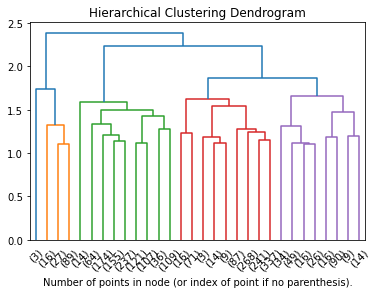

'\nplt.title("Hierarchical Clustering Dendrogram")\nplot_dendrogram(model1_complete, truncate_mode="lastp")\nplt.xlabel("Number of points in node (or index of point if no parenthesis).")\nplt.show()\n\nplt.title("Hierarchical Clustering Dendrogram")\nplot_dendrogram(model2_complete, truncate_mode="lastp")\nplt.xlabel("Number of points in node (or index of point if no parenthesis).")\nplt.show()\n\nplt.title("Hierarchical Clustering Dendrogram")\nplot_dendrogram(model3_complete, truncate_mode="lastp")\nplt.xlabel("Number of points in node (or index of point if no parenthesis).")\nplt.show()'

In [140]:
plt.title("Hierarchical Clustering Dendrogram")
plot_dendrogram(model_complete, truncate_mode="lastp")
plt.xlabel("Number of points in node (or index of point if no parenthesis).")
plt.show()
'''
plt.title("Hierarchical Clustering Dendrogram")
plot_dendrogram(model1_complete, truncate_mode="lastp")
plt.xlabel("Number of points in node (or index of point if no parenthesis).")
plt.show()

plt.title("Hierarchical Clustering Dendrogram")
plot_dendrogram(model2_complete, truncate_mode="lastp")
plt.xlabel("Number of points in node (or index of point if no parenthesis).")
plt.show()

plt.title("Hierarchical Clustering Dendrogram")
plot_dendrogram(model3_complete, truncate_mode="lastp")
plt.xlabel("Number of points in node (or index of point if no parenthesis).")
plt.show()'''

### Minimum

In [141]:
model_single = AgglomerativeClustering(distance_threshold=0, n_clusters=None, affinity='euclidean', linkage='single')
model_single = model_single.fit(X_minmax)
'''
model1_single = AgglomerativeClustering(distance_threshold=0, n_clusters=None, affinity='euclidean', linkage='single')
model1_single = model1_single.fit(X_minmax1)

model2_single = AgglomerativeClustering(distance_threshold=0, n_clusters=None, affinity='euclidean', linkage='single')
model2_single = model2_single.fit(X_minmax2)

model3_single = AgglomerativeClustering(distance_threshold=0, n_clusters=None, affinity='euclidean', linkage='single')
model3_single = model3_single.fit(X_minmax3)'''

"\nmodel1_single = AgglomerativeClustering(distance_threshold=0, n_clusters=None, affinity='euclidean', linkage='single')\nmodel1_single = model1_single.fit(X_minmax1)\n\nmodel2_single = AgglomerativeClustering(distance_threshold=0, n_clusters=None, affinity='euclidean', linkage='single')\nmodel2_single = model2_single.fit(X_minmax2)\n\nmodel3_single = AgglomerativeClustering(distance_threshold=0, n_clusters=None, affinity='euclidean', linkage='single')\nmodel3_single = model3_single.fit(X_minmax3)"

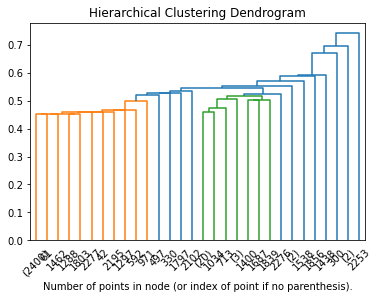

'\nplt.title("Hierarchical Clustering Dendrogram")\nplot_dendrogram(model1_single, truncate_mode="lastp")\nplt.xlabel("Number of points in node (or index of point if no parenthesis).")\nplt.show()\n\nplt.title("Hierarchical Clustering Dendrogram")\nplot_dendrogram(model2_single, truncate_mode="lastp")\nplt.xlabel("Number of points in node (or index of point if no parenthesis).")\nplt.show()\n\nplt.title("Hierarchical Clustering Dendrogram")\nplot_dendrogram(model3_single, truncate_mode="lastp")\nplt.xlabel("Number of points in node (or index of point if no parenthesis).")\nplt.show()'

In [142]:
plt.title("Hierarchical Clustering Dendrogram")
plot_dendrogram(model_single, truncate_mode="lastp")
plt.xlabel("Number of points in node (or index of point if no parenthesis).")
plt.show()
'''
plt.title("Hierarchical Clustering Dendrogram")
plot_dendrogram(model1_single, truncate_mode="lastp")
plt.xlabel("Number of points in node (or index of point if no parenthesis).")
plt.show()

plt.title("Hierarchical Clustering Dendrogram")
plot_dendrogram(model2_single, truncate_mode="lastp")
plt.xlabel("Number of points in node (or index of point if no parenthesis).")
plt.show()

plt.title("Hierarchical Clustering Dendrogram")
plot_dendrogram(model3_single, truncate_mode="lastp")
plt.xlabel("Number of points in node (or index of point if no parenthesis).")
plt.show()'''